# STAT 301 Group 5 Final Report
# "Drivers of Marketing Campaign Response: A Customer Analysis"
# 2025/12/6

---

#### Group Members:
- Nelson Li (32900045)
- Chriscenci Susanto (17538422)
- Yao Xiao (45541596)
- Nariman Avakoli (61193595)

## Introduction

Understanding which types of customers are more likely to engage with marketing campaigns is an important question in consumer analytics. Businesses invest substantial resources into customer research to help guide campaign targeting, yet it is not always clear which factors are most strongly associated with customer engagement. The [Customer Personality Analysis Dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) provides rich demographic and behavioural information which can be used to explore these associations in a statistical way.

In this project, we analyze a marketing campaign dataset containing information on customer demographics, past purchasing behaviour, and previous campaign participation. Our goal is to investigate how these characteristics relate to the likelihood of responding to the company's most recent marketing campaign. Since the data come from an observational setting, our focus is on identifying associations, rather than drawing causal conclusions about the effect of any variable on campaign response.

To guide our analysis, we consider the broad question:

> **What customer characteristics (demographic information, purchasing  behaviour, and past campaign engagement) are associated with responding to the company's most recent marketing campaign?**

Addressing this question requires fitting multiple logistic regression models using a common binary response variable (`Response`) and a set of demographic and behavioural covariates. Since the primary goal of this analysis is inference, we seek to understand which characteristics show statistically significant associations with campaign response. These insights can support businesses in making data-driven marketing decisions.

## Method & Results

### Data

#### Dataset Summary

The [Customer Personality Analysis Dataset](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data) from Kaggle contains demographic, behavioural and spending information about customers. It helps a business better understand its target customers and helps them modify their business strategies according to their specific needs, behaviours and concerns of differnet types of customers.

- Number of observations: 2240 customers
- Number of variables: 29 variables
    - Variables consist of quantitative and categorical data relating to the customer profiles, products, and the response to advertisement campaigns.
- Unique Identifier: `ID`

#### Attribute Table
| Attribute Name | Attribute Grouping | **Data Type** | Variable Type |                            Description                            |
|:--------------:|:------------------:|:--------------:|:--------------:|:-----------------------------------------------------------------:|
| `ID` |       People       | integer |  **continuous** |                   Customer's Unique Identifier                   |
| `Year_Birth` |       People       | integer |    **continuous**  |                    Customer's Birth Year                       |
| `Education` |       People       | object |    **categorical** |                  Customer's education level                    |
| `Marital_Status` |       People       | object |  **categorical**  |                    Customer's marital status                     |
| `Income` |       People       | float |  **continuous** |               Customer's yearly household income                |
| `Kidhome` |       People       | float |**discrete/categorical** |             Number of children in customer's household            |
| `Teenhome` |       People       | float |    **discrete/categorical**|        Number of teenagers in customer's household            |
| `Dt_Customer` |       People       | float |    **date** |        Date of customer's enrollment with the company          |
| `Recency` |       People       | float |  **continuous**  |          Number of days since customer's last purchase           |
| `Complain` |       People       | float |  **categorical**  |  1 if the customer complained in the last 2 years, 0 otherwise   |
| `MntWines` |      Products      | integer |     **continuous**  |            Amount spent on wine in last 2 years               |
| `MntFruits` |      Products      | integer |    **continuous**  |            Amount spent on fruits in last 2 years              |
| `MntMeatProducts` |      Products      | integer |    **continuous**  |             Amount spent on meat in last 2 years               |
| `MntFishProducts` |      Products      | integer |     **continuous**  |            Amount spent on fish in last 2 years               |
| `MntSweetProducts` |      Products      | integer |    **continuous**  |            Amount spent on sweets in last 2 years              |
| `MntGoldProds` |      Products      | integer |        **continuous**  |         Amount spent on gold in last 2 years               |
| `NumDealsPurchases` |     Promotion      | integer |  **discrete/categorical** |            Number of purchases made with a discount             |
| `AcceptedCmp1` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| `AcceptedCmp2` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| `AcceptedCmp3` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| `AcceptedCmp4` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| `AcceptedCmp5` |     Promotion      | integer | **categorical**  | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| `Response` |     Promotion      | integer |**categorical**  |  1 if customer accepted the offer in the last campaign, 0 otherwise |
| `NumWebPurchases` |       Place        | integer |  **discrete/categorical** |    Number of purchases made through the company’s website      |
| `NumCatalogPurchases` |       Place        | integer |   **discrete/categorical**|          Number of purchases made using a catalogue            |
| `NumStorePurchases` |       Place        | integer |  **discrete/categorical** |          Number of purchases made directly in stores            |
| `NumWebVisitsMonth` |       Place        | integer |  **discrete/categorical** |     Number of visits to company’s website in the last month      |
| `Z_CostContact` |       Misc.        | integer |      **-**  |                  No information given                        |
| `Z_Revenue` |       Misc.        | integer |             **-** |                 No information given                        |



#### Source & Information

- Source: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data (created by user `imakash3011`)

#### Pre-selection of variables

**Variables to be dropped**

- `ID` - This is a unique identifier and has no underlying relationship to model.
- `Z_CostContact`, `Z_Revenue` - Have the same (constant) value in all data points. So these two columns are not relevant and can be dropped.
- `Dt_Customer` - Date may not be very useful here especially since `Recency` might be collinear with it.

Note: Although Dt_Customer was flagged as potentially redundant with Recency at this stage, we kept it in the pool of candidate predictors so that the data-driven selection procedures (BIC and LASSO) could decide whether to include it in the final models.

In [15]:
# Loading in libraries
library(tidyverse) # data reading, wrangling
library(rsample) # splitting data
library(car) # vif
library(broom) # tidy model outputs
library(MASS) # stepAIC
library(glmnet) # regularized LASSO

In [16]:
# Reading in data (stored on github)
url <- "https://raw.githubusercontent.com/nelsonli2323/STAT-301-Project/refs/heads/main/marketing_campaign.csv"
customer_data <- read.delim(url, header = TRUE, sep = "\t")

glimpse(customer_data)

Rows: 2,240
Columns: 29
$ ID                  <int> 5524, 2174, 4141, 6182, 5324, 7446, 965, 6177, 485…
$ Year_Birth          <int> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Single", "Single", "Together", "Together", "Marri…
$ Income              <int> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 3…
$ Kidhome             <int> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Teenhome            <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,…
$ Dt_Customer         <chr> "04-09-2012", "08-03-2014", "21-08-2013", "10-02-2…
$ Recency             <int> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68, 11, 59, 82…
$ MntWines            <int> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28, 5, 6,…
$ MntFruits           <int> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0, 5, 16, 61, 2, …
$ MntMeatProducts     <int> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6, 6, 11, 4…
$ MntFishProduct

### Exploratory Data Analysis

#### Cleaning Data

In [17]:
# Count NA values in each column
na_summary <- customer_data %>%
    summarise(across(everything(), ~sum(is.na(.)))) %>%
    pivot_longer(everything(), names_to = "Variable", values_to = "NA_Count") %>%
    filter(NA_Count > 0)

na_summary

Variable,NA_Count
<chr>,<int>
Income,24


The `Income` variable has 24 missing values (`NA`). Since this is a small number realtive to the number of observations we will remove those rows from the dataframe. We will also factorize binary columns, and transform the following variables:

1. `Age` (years) - transformed from `Year_Birth` for interpretability
2. `Total_Spend` ($) - the sum of amount spent on fruits, meat, fish, sweet, and gold
3. `Total_AcceptedCmp` (count) - number of times customer accepted previous campaigns (integer from 0 to 5)

In [18]:
# Getting current year
current_date <- Sys.Date()
current_year <- as.integer(format(current_date, "%Y"))

# Cleaning data, variable transformation, removing unnecessary columns and NA rows
customer_data_clean <- customer_data %>%
    mutate(
        # Variable transformation
        Age = current_year - Year_Birth,
        Total_Spend = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds,
        Total_AcceptedCmp = AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5,
        
        # Formatting variables
        Education = as.factor(Education),
        Marital_Status = as.factor(Marital_Status),
        Dt_Customer = as.Date(Dt_Customer, format = "%d-%m-%Y"),
        Response = as.factor(Response),
        Complain = as.factor(Complain),
        AcceptedCmp1 = as.factor(AcceptedCmp1),
        AcceptedCmp2 = as.factor(AcceptedCmp2),
        AcceptedCmp3 = as.factor(AcceptedCmp3),
        AcceptedCmp4 = as.factor(AcceptedCmp4),
        AcceptedCmp5 = as.factor(AcceptedCmp5)
    ) %>%
    dplyr::select(-ID, -Z_CostContact, -Z_Revenue) %>%
    filter(!if_any(everything(), is.na))

glimpse(customer_data_clean)

Rows: 2,216
Columns: 29
$ Year_Birth          <int> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 19…
$ Education           <fct> Graduation, Graduation, Graduation, Graduation, Ph…
$ Marital_Status      <fct> Single, Single, Together, Together, Married, Toget…
$ Income              <int> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 3…
$ Kidhome             <int> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,…
$ Teenhome            <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,…
$ Dt_Customer         <date> 2012-09-04, 2014-03-08, 2013-08-21, 2014-02-10, 2…
$ Recency             <int> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68, 59, 82, 53…
$ MntWines            <int> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28, 6, 19…
$ MntFruits           <int> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0, 16, 61, 2, 14,…
$ MntMeatProducts     <int> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6, 11, 480,…
$ MntFishProducts     <int> 172, 2, 111, 10, 46, 0, 50, 3, 3, 1, 11, 225, 3, 6…
$ MntSweetProduc

#### Visualizations

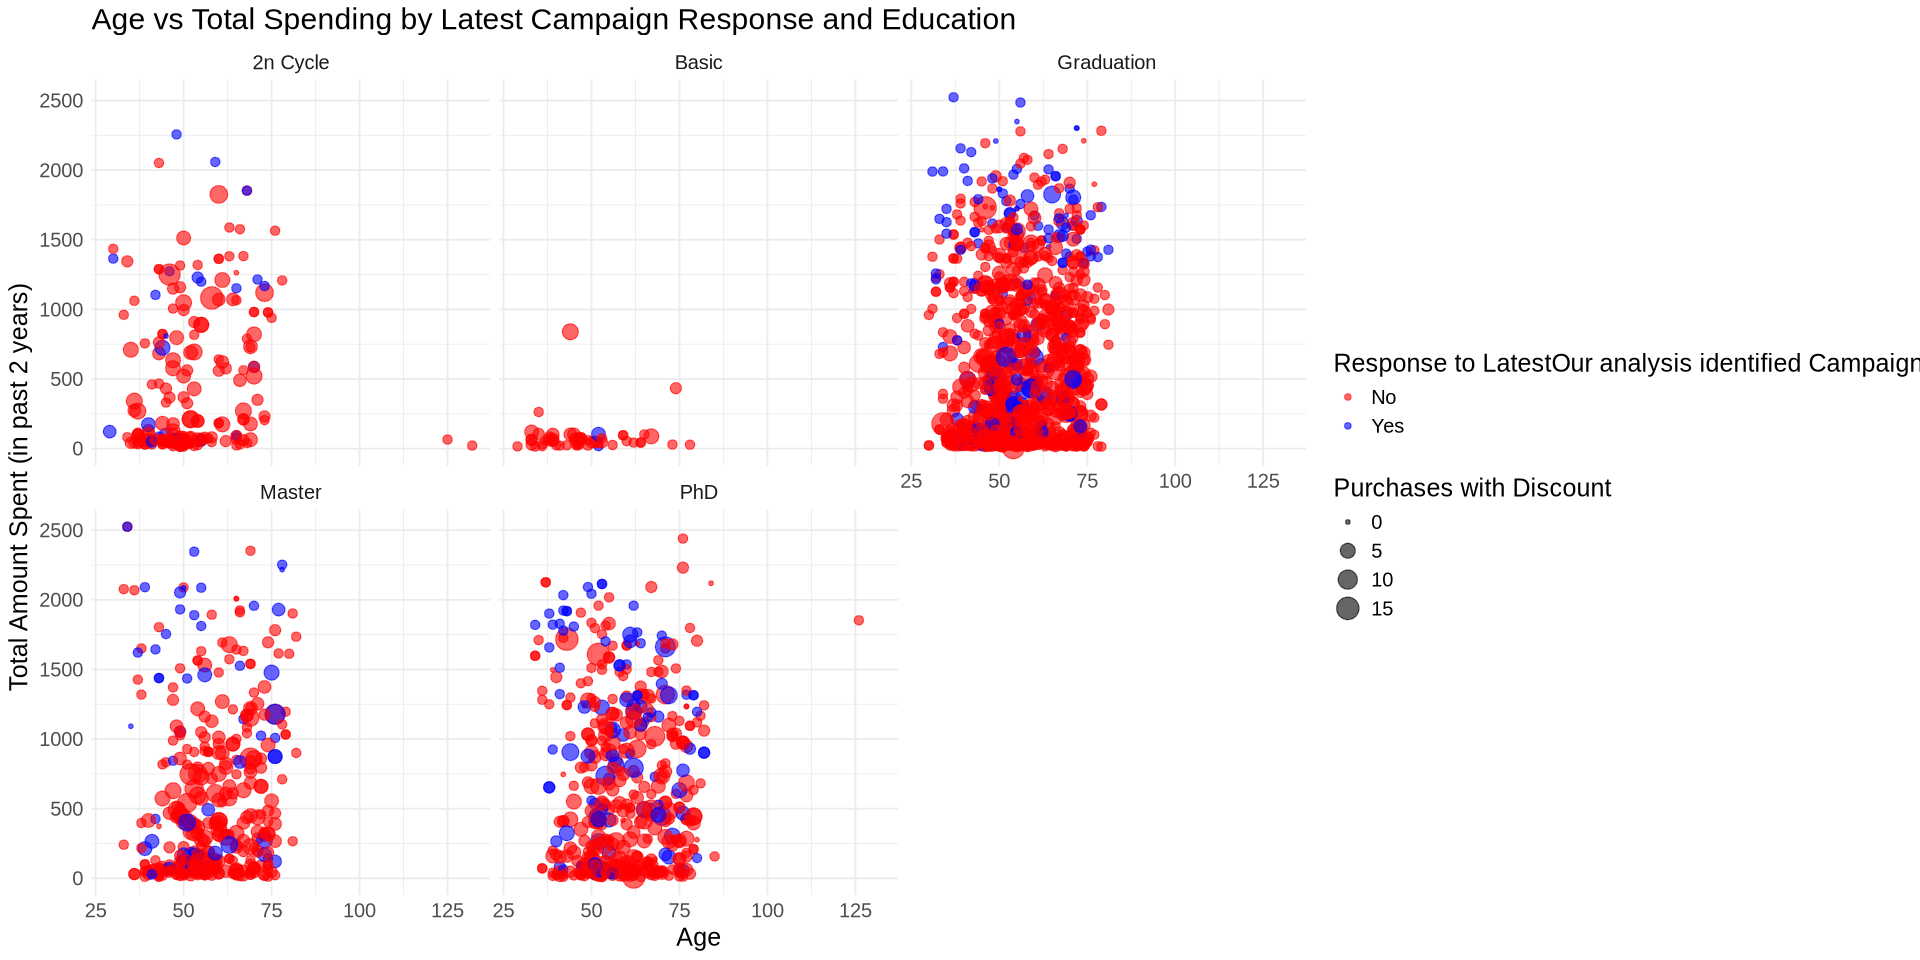

In [19]:
# Visualization 1
options(repr.plot.width = 16, repr.plot.height = 8)

customer_data_clean %>%
    ggplot(aes(x = Age, y = Total_Spend, colour = Response, size = NumDealsPurchases)) +
    geom_point(alpha = 0.6) +
    facet_wrap(~Education) +
    scale_color_manual(
        values = c("0" = "red", "1" = "blue"),
        labels = c("0" = "No", "1" = "Yes")
    ) +
    labs(
        title = "Age vs Total Spending by Latest Campaign Response and Education",
        x = "Age",
        y = "Total Amount Spent (in past 2 years)",
        colour = "Response to LatestOur analysis identified Campaign",
        size = "Purchases with Discount"
    ) +
    theme_minimal() + 
    theme(text = element_text(size = 15))

The plot above examines the relationship between `Age`, `Total_Spend` and discount purchase behaviour (`NumDealsPurchased`), faceted by `Education` and coloured by the most recent campaign `Response`.

The visualization reveals that age does not show a strong relationship with total spending across education levels. Customers who responded to the most recent campaign (blue points) are generally found in the mid-to-high spending ranges, particularly among those with Graduation, Master, or PhD education levels. Larger points (more discount purchases) tend to cluster at the low-to-mid spending levels, suggesting that frequent use of discounts does not necessarily indicate high overall spending.

Overall, this plot suggests that higher education and higher total spending are associated with a greater likelihood of responding to campaigns.

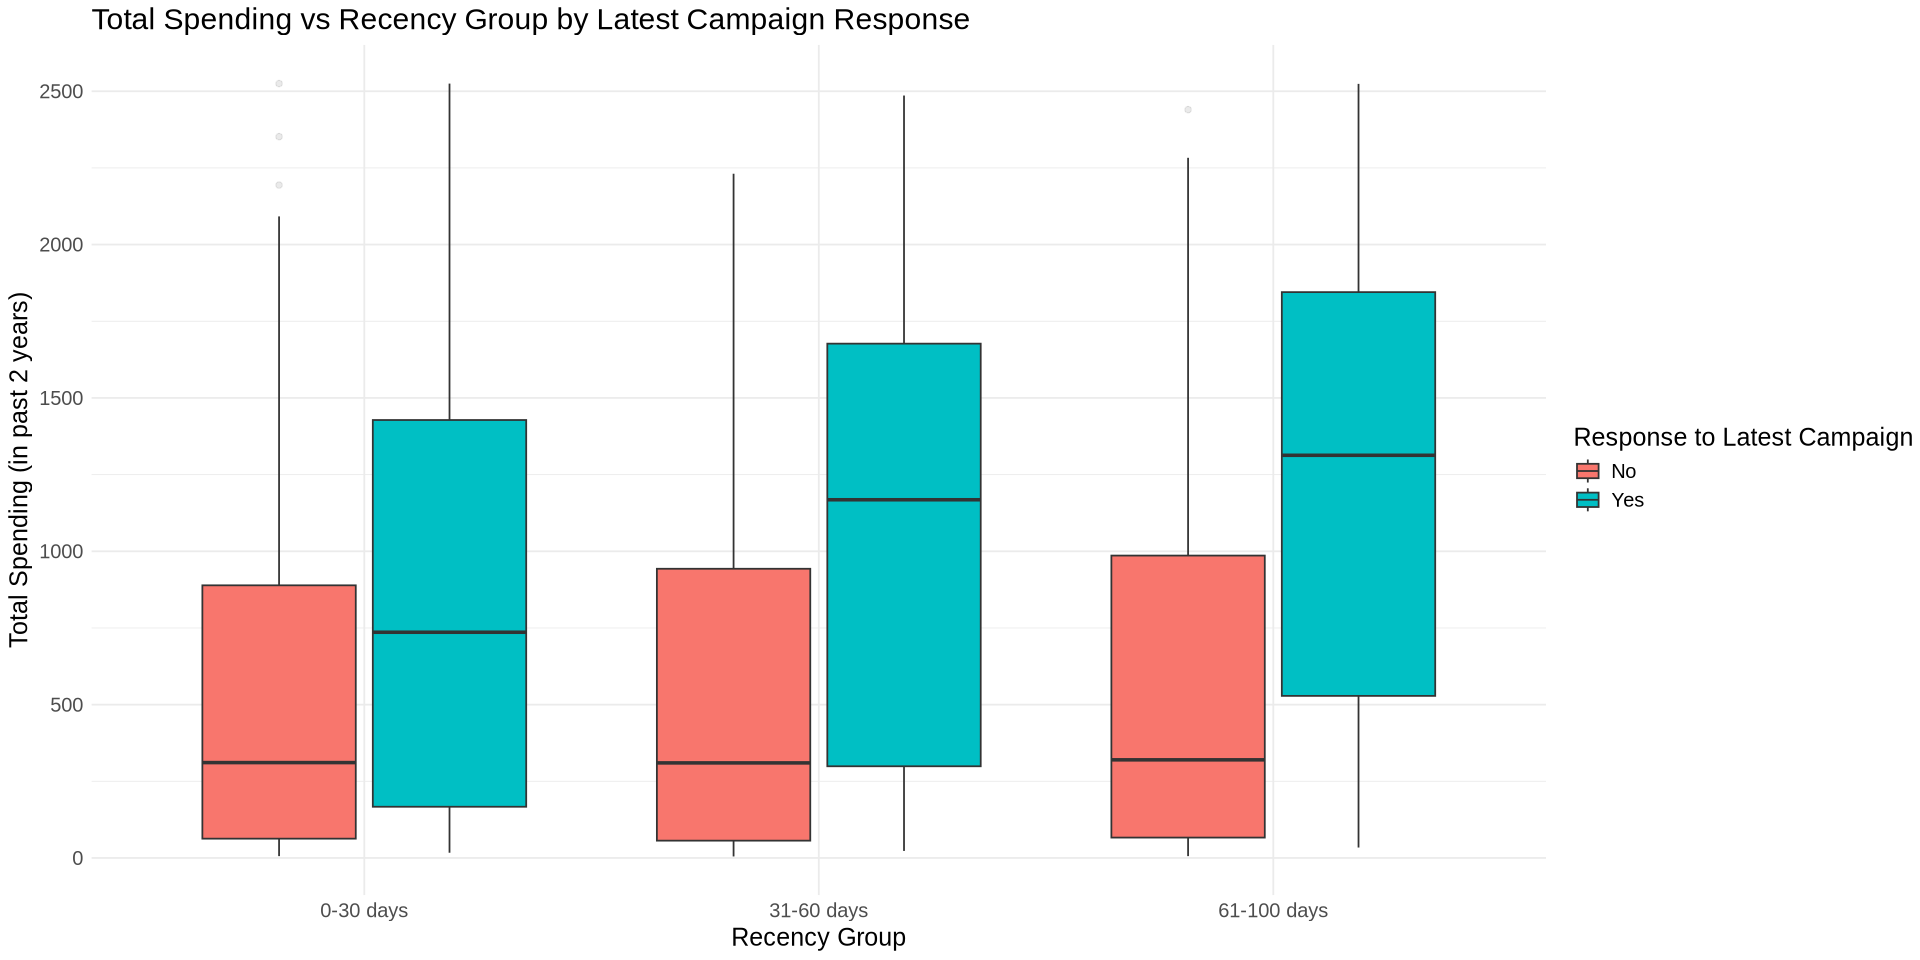

In [20]:
# Visualization 2
options(repr.plot.width = 16, repr.plot.height = 8)

# Grouping recency into 30 day intervals
customer_plot <- customer_data_clean %>%
  mutate(
    response_f = dplyr::recode(as.character(Response), "0" = "No", "1" = "Yes"),
    RecencyGroup = cut(
      Recency,
      breaks = c(0, 30, 60, 100),
      labels = c("0-30 days", "31-60 days", "61-100 days"),
      include.lowest = TRUE
    )
  )

customer_plot %>%
    ggplot(aes(x = RecencyGroup, y = Total_Spend, fill = response_f)) +
    geom_boxplot(outlier.alpha = 0.1) +
    labs(
        title = "Total Spending vs Recency Group by Latest Campaign Response",
        x = "Recency Group",
        y = "Total Spending (in past 2 years)",
        fill = "Response to Latest Campaign"
    ) +
    theme_minimal() +
    theme(text = element_text(size = 15))

This plot groups customers by `Recency` of last purchase and compares the distribution of `Total_Spend` in the past two years, separated by whether they accepted the last campaign offer. It directly addresses our scientific question, because it combines two key aspects of historical engagement(`Recency` and `spending level`) and shows how these patterns differ between customers who accepted and did not accept the offer.

Across all recency groups, customers who accepted the offer tend to have higher median spending and a wider upper range than those who did not. In other words, acceptance is more common among higher-spending customers, regardless of how recent their last purchase was. The lowest spending levels are concentrated among non-acceptors in every group.

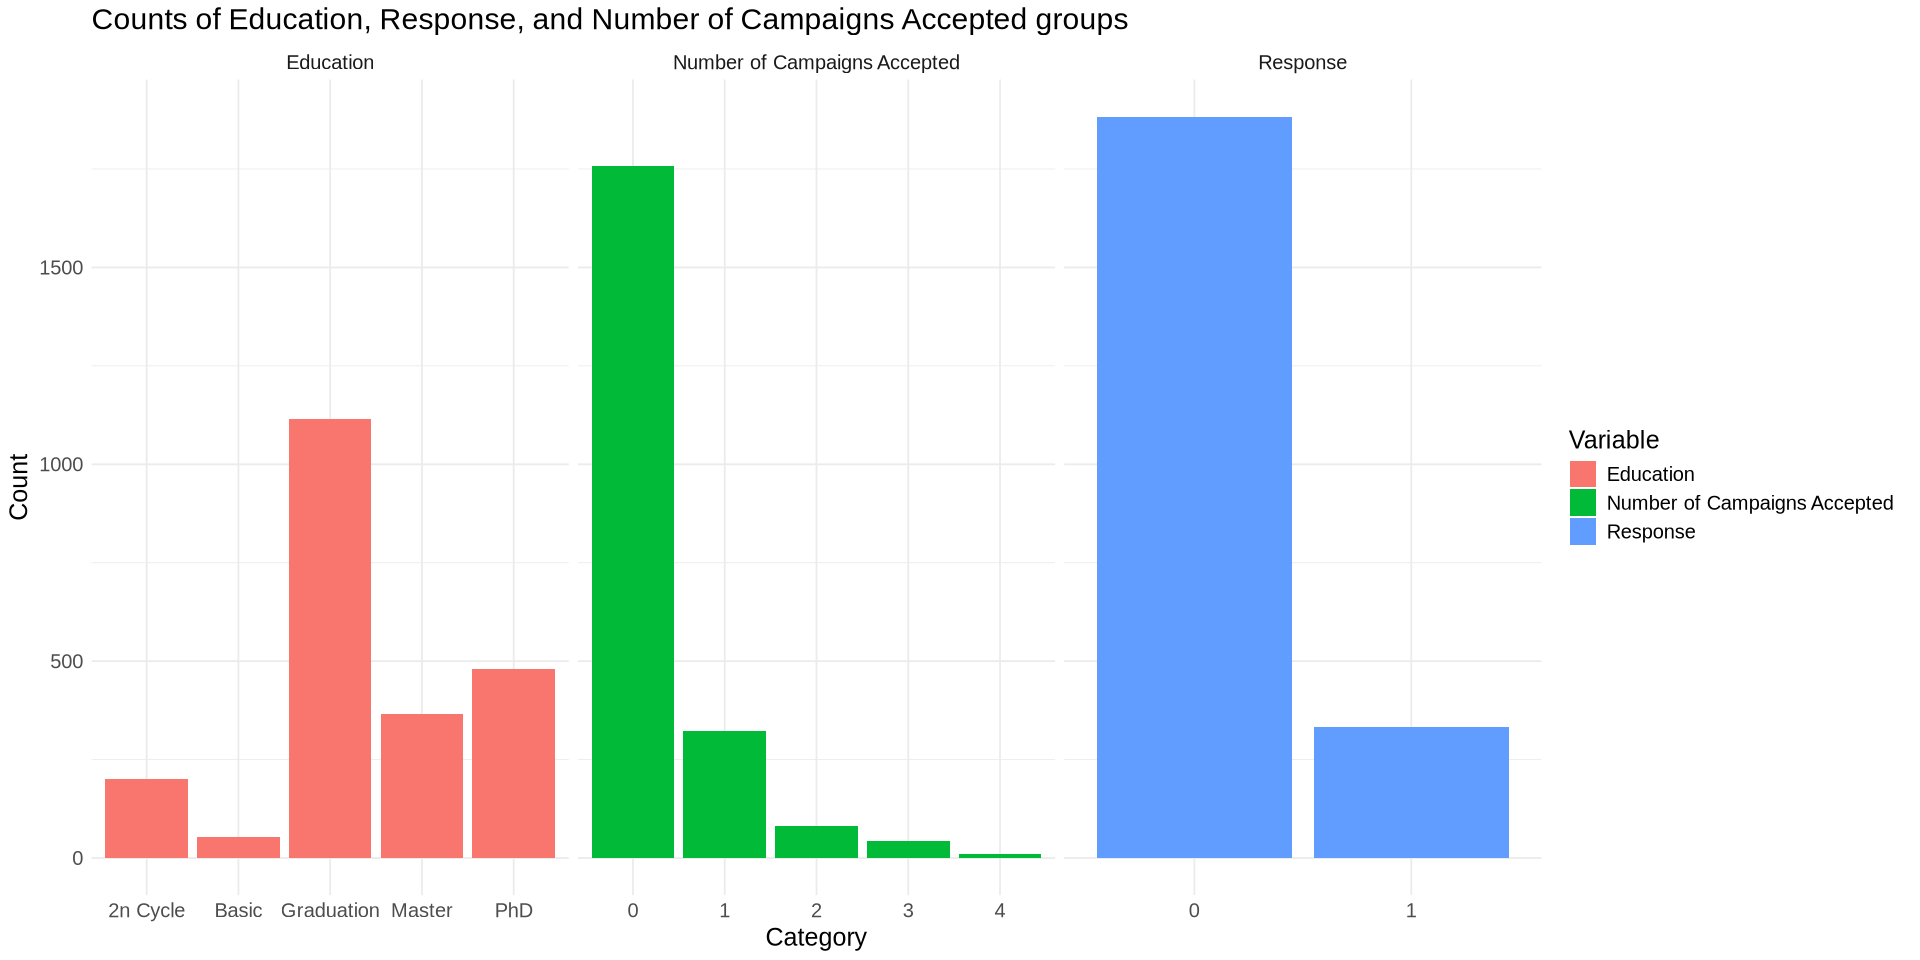

In [21]:
options(repr.plot.width = 16, repr.plot.height = 8)

# Helper function to create standardized summary tables
create_summary_table <- function(var_name, variable_label) {
  customer_data_clean %>%
    group_by({{ var_name }}) %>%
    summarize(Count = n()) %>%
    rename(Category = {{ var_name }}) %>%
    mutate(Variable = variable_label, Category = as.factor(Category))
}

# Create plotting data
response_table <- create_summary_table(Response, "Response")
education_table <- create_summary_table(Education, "Education")
accepted_table <- create_summary_table(Total_AcceptedCmp, "Number of Campaigns Accepted")

plot_data_long <- bind_rows(response_table, education_table, accepted_table)

plot_data_long %>%
    ggplot(aes(x = Category, y = Count, fill = Variable)) +
    geom_bar(stat = "identity") +
    facet_wrap(~Variable, scales = "free_x") +
    labs(title = "Counts of Education, Response, and Number of Campaigns Accepted groups") +
    theme_minimal() +
    theme(text = element_text(size = 15))

The plot above displays the distribution of three key variables: `Response`, `Education`, and `Total_AcceptedCmp`.

- `Response`: the majority of customers did not respond to the last campaign
- `Education`: Graduation is the most frequent education level followed by PhD and Master
- `Total_AcceptedCmp`: Most customers accepted 0 or 1 past campaign(s) with fewer customers accepting 2-4 past campaigns. No customers accepted all 5 past campaigns.

### Methods: Plan

Our goal is to identify which customer characteristics are associated with responding to the most recent marketing campaign. Since the response variable is binary, we will use an additive logistic regression model to examine how demographic  characteristics (age, education, income, etc.), past spending behaviours (amounts spend on different product categories), and previous participation with campaigns are associated with the likelihood of responding to the last marketing campaign (`Response`). An additive logistic regression is the natural choice for this analysis as it models the log-odds of a binary outcome using a linear model while still remaining interpretable.

We will follow a two-stage variable selection strategy:

1. **Information-criterion Approach**: Using stepwise BIC to select covariates which is preferred over adjusted $R^2$ because $R^2$ does not apply to logistic regression models.
2. **Regularization Method**: Using LASSO which shrinks coefficient estimates (possible to 0) and performs data-driven variable selection. While LASSO can select individual dummy variables within a categorical predictor, we will retain the entire categorical variable if *all* its levels are selected.

To avoid overfitting, we divide the data into two parts with proportionally allocated `Response` variable:

1. **Model selection set**: $40\%$ of the original dataset
2. **Inference set**: $60\%$ of the original dataset

The two selection methods are applied only to the model-selection set. Multicollinearity will be checked using `vif` and the resulting candidate models are then refit on the inference set for final parameter estimation. This helps debias the effect of LASSO (postLASSO). As the main goal of this model is for inference, model assessment is mainly based on the deviance test and information criteria (AIC / BIC). The final model is chosen based on interpretability and evidence of adequate fit on the inference set.

### Code & Results

#### Splitting Data

We first split the data into the selection set ($40\%$) and an inference set ($60\%$).

In [22]:
# Spliting dataset into model selection and inference sets
set.seed(301) # for reproducibility
customer_split <- initial_split(customer_data_clean, prop = 0.4, strata = Response)
selection_set <- training(customer_split)
inference_set <- testing(customer_split)

cat("Number of customers in Selection Set: ", nrow(selection_set), "\n")
cat("Number of customers in Inference Set: ", nrow(inference_set))

Number of customers in Selection Set:  886 
Number of customers in Inference Set:  1330

#### Model 1 - Stepwise BIC

We will create the stepwise BIC model and check for multicollinearity using `vif`.

In [23]:
# Full model
full_model <- glm(Response ~ ., data = selection_set, family = "binomial")

# Null model
null_model <- glm(Response ~ 1, data = selection_set, family = "binomial")

# Stepwise BIC selection
n <- nrow(selection_set)
BIC_model <- stepAIC(
    null_model, 
    direction = "forward",
    scope = list(lower = null_model, upper = full_model),
    k = log(n),
    trace = FALSE
)

# Checking multicollinearity
bic_vif <- tibble(term = names(vif(BIC_model)), vif = vif(BIC_model))
bic_vif

term,vif
<chr>,<dbl>
Total_AcceptedCmp,1.546247
Dt_Customer,1.176338
Recency,1.106335
Teenhome,1.387211
AcceptedCmp3,1.246014
NumDealsPurchases,1.405818
MntMeatProducts,1.523863
NumStorePurchases,1.618580


As none of the vif values are larger than $\sqrt{5} \approx 2.236$, multicollinearity should not be an issue and we can use the same formula to construct the model on the inference set.

In [24]:
# Fitting the Stepwise-BIC model on the inference_set
inf_BIC_model <- glm(BIC_model$formula, data = inference_set, family = "binomial")

# Stepwise-BIC model results (without intercept)
BIC_results <- tidy(inf_BIC_model, exponentiate = FALSE)[-1,] %>%
    mutate(exp_estimate = exp(estimate)) %>%
    dplyr::select(term, estimate, exp_estimate, p.value) %>%
    mutate_if(is.numeric, round, 4)

BIC_results
print("Table 3.1: Coefficient estimates and exponentiated estimates from the Stepwise-BIC model")

term,estimate,exp_estimate,p.value
<chr>,<dbl>,<dbl>,<dbl>
Total_AcceptedCmp,1.4786,4.3867,0.0000
Dt_Customer,-0.0041,0.9959,0.0000
Recency,-0.0312,0.9692,0.0000
Teenhome,-0.5479,0.5782,0.0116
AcceptedCmp31,0.4728,1.6045,0.1197
NumDealsPurchases,0.1145,1.1213,0.0306
MntMeatProducts,0.0021,1.0021,0.0000
NumStorePurchases,-0.1100,0.8958,0.0031


[1] "Table 3.1: Coefficient estimates and exponentiated estimates from the Stepwise-BIC model"


From Table 3.1 above, we see that all estimated coefficients except for `AcceptedCmp3` are statistically significant at the $5\%$ level.

- `Total_AcceptedCmp` has a positive coefficient of 1.49. This means that holding all other variables in the model constant, each additional previously accepted campaign is associated with an increase in the expected odds of responding to the latest campaign by a factor of $e^{1.49} = 4.39$.
- `Dt_Customer` and `Recency` have negative coefficients, suggesting that more recent customers or those with a shorter recency period are slightly less likely to respond, after controlling for other variables.
- `Teenhome` has a negative coefficient, suggesting that households with teenagers are associated with having lower response rates, possibly due to busy schedules.
- `NumDealsPurchases` and `MntMeatProducts` are positive and significant, suggesting that customers who frequently purchase deals or spend more on meat products are slightly more likely to respond.
- `NumStorePurchases` is negative, indicating that higher in-store purchase frequency is associated with slightly lower campaign response probability.
- `AcceptedCmp3` is not statistically significant, implying no strong evidence that acceptance of the third campaign is associated with response to the most recent campaign when controlling for other covariates.

#### Model 2 - LASSO Regularized

We will use cross validation to find the optimal $\lambda$ parameter for our LASSO regularized model.

In [25]:
# Fromatting inputs
X <- model.matrix(Response ~ ., data = selection_set)[,-1]
Y <- selection_set$Response

set.seed(301) # For reproducibility

# CV to find optimal lambda
cv_lasso <- cv.glmnet(x = X, y = Y, alpha = 1, nfolds = 10, family = "binomial")

lambda_min <- cv_lasso$lambda.min
coef_min <- coef(cv_lasso, s = lambda_min)
coef_min

38 x 1 sparse Matrix of class "dgCMatrix"
                                  s1
(Intercept)             6.268889e+01
Year_Birth             -2.793155e-03
EducationBasic         -3.605350e-01
EducationGraduation     .           
EducationMaster         .           
EducationPhD            7.344344e-01
Marital_StatusAlone     .           
Marital_StatusDivorced  1.027876e+00
Marital_StatusMarried   .           
Marital_StatusSingle    9.253512e-01
Marital_StatusTogether -2.683515e-01
Marital_StatusWidow     4.429728e-01
Marital_StatusYOLO      .           
Income                  .           
Kidhome                 .           
Teenhome               -1.039106e+00
Dt_Customer            -3.716422e-03
Recency                -2.453831e-02
MntWines                .           
MntFruits               1.885397e-05
MntMeatProducts         1.417837e-03
MntFishProducts         .           
MntSweetProducts        1.005697e-03
MntGoldProds            1.041506e-03
NumDealsPurchases       1.753820e

We will perform postLASSO by fitting the model on the selected covariates. We will only include covariates if all there levels are selected and remove collinear covariates. Multicollinearity will be checked again using `vif`.

In [26]:
# Fitting the LASSO selected covariates on the inference_set
inf_LASSO_model <- glm(
    Response ~ Teenhome + Dt_Customer + Recency + MntFruits + MntMeatProducts + MntSweetProducts + MntGoldProds +
               NumDealsPurchases + NumWebPurchases + NumStorePurchases + Age + Total_AcceptedCmp,
    data = inference_set,
    family = "binomial"
)

# Checking multicollinearity
LASSO_vif <- tibble(term = names(vif(inf_LASSO_model)), vif = vif(inf_LASSO_model))
LASSO_vif

term,vif
<chr>,<dbl>
Teenhome,1.523123
Dt_Customer,1.155754
Recency,1.092713
MntFruits,1.740899
MntMeatProducts,1.899693
MntSweetProducts,1.636868
MntGoldProds,1.289176
NumDealsPurchases,1.441721
NumWebPurchases,1.419319


As none of the vif values are larger than $\sqrt{5} \approx 2.236$, multicollinearity should not be an issue here.

In [27]:
# postLASSO model results
LASSO_results <- tidy(inf_LASSO_model, exponentiate = FALSE)[-1,] %>%
    mutate(exp_estimate = exp(estimate)) %>%
    dplyr::select(term, estimate, exp_estimate, p.value) %>%
    mutate_if(is.numeric, round, 4)

LASSO_results
print("Table 3.2: Coefficient estimates and exponentiated estimates from the LASSO regularized model")

term,estimate,exp_estimate,p.value
<chr>,<dbl>,<dbl>,<dbl>
Teenhome,-0.7454,0.4745,0.0014
Dt_Customer,-0.0040,0.9960,0.0000
Recency,-0.0305,0.9700,0.0000
MntFruits,0.0008,1.0008,0.7998
MntMeatProducts,0.0019,1.0019,0.0005
MntSweetProducts,-0.0029,0.9971,0.3207
MntGoldProds,0.0012,1.0012,0.5330
NumDealsPurchases,0.0915,1.0958,0.0901
NumWebPurchases,0.1148,1.1217,0.0018


[1] "Table 3.2: Coefficient estimates and exponentiated estimates from the LASSO regularized model"


From the LASSO model (Table 3.2), we see that several coefficients are statistically significant at the $5\%$ level, including `Total_AcceptedCmp`, `Recency`, `Dt_Customer`, `MntMeatProducts`, `NumWebPurchases`, `NumStorePurchases`, and `Teenhome`.

- `Total_AcceptedCmp` again shows the strongest positive association with campaign response, consistent with the Stepwise-BIC model.
- `Recency` and `Dt_Customer` are negative, indicating that newer customers or those with shorter recency periods have slightly lower response probabilities.
- `MntMeatProducts` and `NumWebPurchases` are positive and significant, suggesting higher meat spending and more web purchases are associated with higher likelihood of responding.
- `NumStorePurchases` is negative, indicating that more frequent in-store buyers are slightly less likely to respond.
- `Teenhome` remains negative, consistent with the BIC model.

Some variables selected by LASSO, like `MntFruits`, `MntSweetProducts`, `MntGoldProds`, and `Age`, are not statistically significant, which suggests that there is no strong evidence that these covariates are associated with responding to the most recent campaign.

In [28]:
# Deviance test
null_model <- glm(Response ~ 1, data = inference_set, family = "binomial")
p_value <- function(model) {
    df <- anova(null_model, model, test = "Chisq")[2,]
    df$`Pr(>Chi)`
}

# Stepwise-BIC summary
bic_summary <- tibble(
    Model = "Stepwise-BIC",
    Num_Covariates = nrow(BIC_results),
    Significant_Covariates = sum(BIC_results$p.value < 0.05),
    AIC = AIC(inf_BIC_model),
    BIC = BIC(inf_BIC_model),
    Null_Deviance = inf_BIC_model$null.deviance,
    Residual_Deviance = inf_BIC_model$deviance,
    Deviance_p_value = p_value(inf_BIC_model),
)

# LASSO summary
lasso_summary <- tibble(
    Model = "LASSO",
    Num_Covariates = nrow(LASSO_results),
    Significant_Covariates = sum(LASSO_results$p.value < 0.05),
    AIC = AIC(inf_LASSO_model),
    BIC = BIC(inf_LASSO_model),
    Null_Deviance = inf_LASSO_model$null.deviance,
    Residual_Deviance = inf_LASSO_model$deviance,
    Deviance_p_value = p_value(inf_LASSO_model),
)

# Comparison Table
model_comparison <- bind_rows(bic_summary, lasso_summary) %>%
    mutate_if(is.numeric, round, 4)

model_comparison
print("Table 3.3: Summary statistics comparing Stepwise-BIC and LASSO models")

Model,Num_Covariates,Significant_Covariates,AIC,BIC,Null_Deviance,Residual_Deviance,Deviance_p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stepwise-BIC,8,7,757.3305,804.0669,1126.139,739.3305,0
LASSO,12,7,754.5824,822.0906,1126.139,728.5824,0


[1] "Table 3.3: Summary statistics comparing Stepwise-BIC and LASSO models"


From Table 3.3, we see that both models have comparable numbers of statistically significant covariates (7 each). The LASSO model includes more covariates overall (12 vs. 8) and has slightly lower residual deviance and AIC, indicating a marginally better fit to the data. However, the Stepwise-BIC model has a lower BIC, reflecting a more parsimonious model that balances fit and complexity. Both models were significantly better than the null model from the results of the deviance test.

Key differences between the models:
- **Stepwise-BIC**: Performs variable selection using information criteria, producing a smaller, simpler model. Emphasizes interpretability and reduces the risk of overfitting.
- **LASSO**: Uses regularization to shrink coefficients and select variables, often retaining more covariates. Can handle correlated predictors better but may include small, less meaningful effects due to shrinkage.

Since our main goal is inference and understanding which variables are associated with campaign response, the Stepwise-BIC model is preferred. Its has a simpler set of covariates making it more interpretable while still statistically fitting the data better than the null model. It also has the same number of significant coefficients as the LASSO model.

## Discussion

Our analysis identified several customer characteristics associated with responding to the most recent marketing campaign. Both models highlighted higher total campaign acceptance (`Total_AcceptedCmp`) and certain purchasing behaviours (ie. `NumDealsPurchases`) as positive predictors, while some attributes such as `Recency` and `Teenhome` showed a negative association. These results suggest that customers with a history of engagement and higher spending are more likely to respond while customers who have made a purchase recently or with teens at home are less likely to respond. While these are not causally related, their associations offer actionable insights for targeted marketing.

Because this dataset is observational and we cannot control how customers were exposed to campaigns, our results may be influenced by unmeasured factors like brand loyalty or economic conditions. Variables such as Total_AcceptedCmp and Total_Spend may also reflect an underlying high-engagement customer type, which our models cannot isolate. Repeated variable selection with Stepwise BIC and LASSO may further exaggerate some associations.

The findings largely align with expectations as frequent engagement and more purchases with deals naturally predict responsiveness. The Stepwise-BIC model produced a smaller, more interpretable set of covariates, making it ideal for inference, whereas the LASSO model retained additional variables that may highlight supplementary factors. Both models were significantly better than the null model, as confirmed by the deviance test.

Future improvements could include modeling interactions between demographics and spending behaviours or incorporating temporal patterns from previous campaigns to capture dynamic customer preferences. Overall, this study demonstrates that statistical modeling of campaign response can guide marketing decisions and lays the groundwork for further research into customer engagement patterns.

## References

The data was collected by Dr. Omar Romero-Hernandez, a Professor at U.C. Berkeley’s Haas School of Business from data provided by ad campaigns. 
- The data can be accessed via this URL: https://www.kaggle.com/jackdaoud/marketing-data (Marketing Analytics).